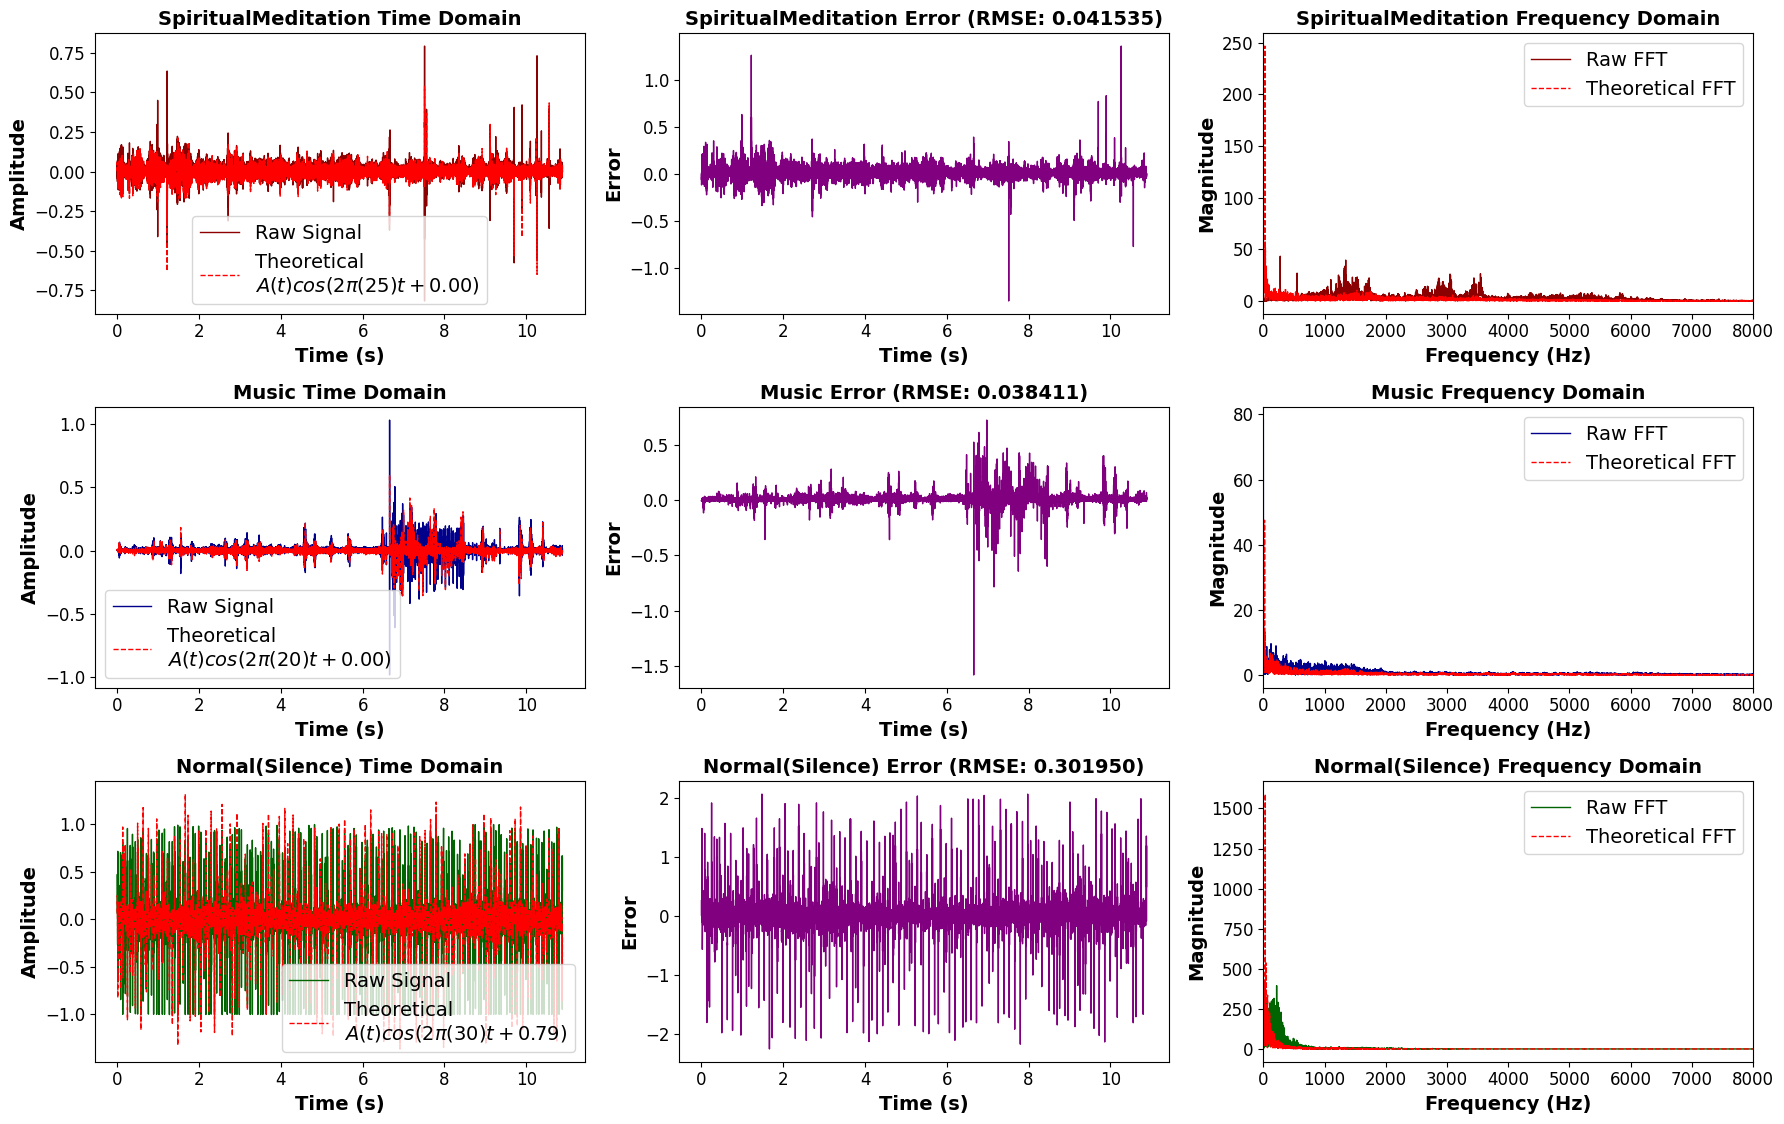


Summary Statistics for Each Class:
              Class     RMSE  Mean Envelope  Std Envelope      Energy
SpiritualMeditation 0.041535       0.029535      0.028306  149.660294
              Music 0.038411       0.019994      0.033771  136.900772
    Normal(Silence) 0.301950       0.190710      0.231877 7853.962402


In [1]:
import os
import random
import glob
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import hilbert
from pathlib import Path
import pandas as pd

# ----------------------------
# Global Settings
# ----------------------------
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 12

# Define dark colors for each class.
class_colors = {
    "SpiritualMeditation": "#8B0000",      # Dark Red
    "Music": "#00008B",                   # Dark Blue
    "Normal(Silence)": "#006400"          # Dark Green
}

# ----------------------------
# 1. Raw Audio Dataset
# ----------------------------
class RawAudioDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, sample_rate=16000):
        self.sample_rate = sample_rate
        # Update class names as per your dataset.
        self.classes = ["SpiritualMeditation", "Music", "Normal(Silence)"]
        self.file_paths = []
        self.labels = []
        for cls in self.classes:
            folder = Path(root_dir) / cls
            wav_files = glob.glob(str(folder / '*.wav'))
            # Only add if files exist.
            if wav_files:
                self.file_paths.extend(wav_files)
                self.labels.extend([cls] * len(wav_files))
            else:
                print(f"Warning: No files found for class '{cls}' in folder {folder}.")
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, sr = torchaudio.load(file_path)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        # Use only the first channel if stereo.
        if waveform.dim() == 2:
            waveform = waveform[0].unsqueeze(0)
        label = self.labels[idx]
        return waveform, label

# ----------------------------
# 2. Signal Processing Functions
# ----------------------------
def compute_amplitude_envelope(waveform):
    data = waveform.numpy().flatten()
    analytic_signal = hilbert(data)
    envelope = np.abs(analytic_signal)
    return envelope

def theoretical_signal(envelope, t, fc, phi):
    return envelope * np.cos(2 * np.pi * fc * t + phi)

def compute_rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

def compute_fft(waveform, sample_rate=16000, fft_size=16384):
    data = waveform.numpy().flatten()
    if len(data) < fft_size:
        data_fixed = np.pad(data, (0, fft_size - len(data)), mode='constant')
    else:
        data_fixed = data[:fft_size]
    fft_vals = np.fft.fft(data_fixed)
    fft_freq = np.fft.fftfreq(len(fft_vals), 1.0/sample_rate)
    pos_mask = fft_freq >= 0
    return fft_freq[pos_mask], np.abs(fft_vals)[pos_mask]

# ----------------------------
# 3. Statistical Analysis
# ----------------------------
def compute_time_stats(waveform):
    data = waveform.numpy().flatten()
    rms = np.sqrt(np.mean(data**2))
    mean_val = np.mean(data)
    std_val = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    energy = np.sum(data**2)
    return {"RMS": rms, "Mean": mean_val, "Std": std_val, "Min": min_val, "Max": max_val, "Energy": energy}

# ----------------------------
# 4. Main Processing and Plotting Function
# ----------------------------
def process_and_plot(sample_rate=16000, fft_size=16384):
    # Update dataset root directory as needed.
    root_dir = '/kaggle/input/qmsat-dataset/ATS-data'
    dataset = RawAudioDataset(root_dir, sample_rate=sample_rate)
    
    # Define class-specific parameters.
    params = {
        "SpiritualMeditation": {"fc": 25, "phi": 0},
        "Music": {"fc": 20, "phi": 0},
        "Normal(Silence)": {"fc": 30, "phi": np.pi/4}
    }
    
    summary_list = []
    
    # Create one figure with 3 rows and 3 columns.
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    for i, cls in enumerate(dataset.classes):
        # Check if there are any samples for this class.
        indices = [j for j, lab in enumerate(dataset.labels) if lab == cls]
        if not indices:
            print(f"Skipping class {cls}: no samples found.")
            continue
        sample_idx = random.choice(indices)
        waveform, _ = dataset[sample_idx]
        data = waveform.numpy().flatten()
        N = len(data)
        t = np.linspace(0, N/sample_rate, N)
        
        envelope = compute_amplitude_envelope(waveform)
        fc = params[cls]["fc"]
        phi = params[cls]["phi"]
        theo = theoretical_signal(envelope, t, fc, phi)
        rmse = compute_rmse(data, theo)
        
        stats = {
            "Class": cls,
            "RMSE": rmse,
            "Mean Envelope": np.mean(envelope),
            "Std Envelope": np.std(envelope),
            "Energy": np.sum(data**2)
        }
        summary_list.append(stats)
        
        freq_raw, fft_raw = compute_fft(waveform, sample_rate, fft_size)
        theo_tensor = torch.tensor(theo)
        freq_theo, fft_theo = compute_fft(theo_tensor, sample_rate, fft_size)
        
        # Column 1: Time-domain overlay.
        axs[i, 0].plot(t, data, color=class_colors[cls], label="Raw Signal", linewidth=1)
        axs[i, 0].plot(t, theo, color="red", linestyle="--", 
                       label=f"Theoretical\n$A(t)cos(2π({fc})t+{phi:.2f})$", linewidth=1)
        axs[i, 0].set_xlabel("Time (s)", fontsize=14, fontweight="bold")
        axs[i, 0].set_ylabel("Amplitude", fontsize=14, fontweight="bold")
        axs[i, 0].set_title(f"{cls} Time Domain", fontsize=14, fontweight="bold")
        axs[i, 0].legend(fontsize=14)
        
        # Column 2: Error signal.
        error = data - theo
        axs[i, 1].plot(t, error, color="purple", linewidth=1)
        axs[i, 1].set_xlabel("Time (s)", fontsize=14, fontweight="bold")
        axs[i, 1].set_ylabel("Error", fontsize=14, fontweight="bold")
        axs[i, 1].set_title(f"{cls} Error (RMSE: {rmse:.6f})", fontsize=14, fontweight="bold")
        
        # Column 3: Frequency-domain overlay.
        axs[i, 2].plot(freq_raw, fft_raw, color=class_colors[cls], linewidth=1, label="Raw FFT")
        axs[i, 2].plot(freq_theo, fft_theo, color="red", linestyle="--", 
                       label="Theoretical FFT", linewidth=1)
        axs[i, 2].set_xlabel("Frequency (Hz)", fontsize=14, fontweight="bold")
        axs[i, 2].set_ylabel("Magnitude", fontsize=14, fontweight="bold")
        axs[i, 2].set_title(f"{cls} Frequency Domain", fontsize=14, fontweight="bold")
        axs[i, 2].set_xlim([0, sample_rate/2])
        axs[i, 2].legend(fontsize=14)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("/kaggle/working/signal_comparison_all_classes.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    df_summary = pd.DataFrame(summary_list)
    print("\nSummary Statistics for Each Class:")
    print(df_summary.to_string(index=False))

# ----------------------------
# 5. Main Execution
# ----------------------------
if __name__ == "__main__":
    process_and_plot()
